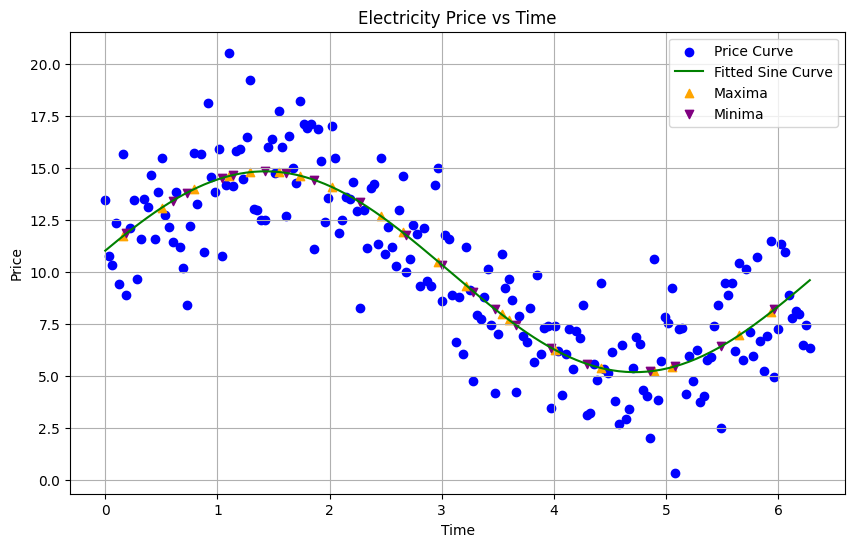

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema

# Define the function to fit (in this case, a sine function)


def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(frequency * x + phase) + offset


# Generate time points
num_points = 200
time = np.linspace(0, 2 * np.pi, num_points)

# Generate a sine curve for price points with added noise for realism
amplitude = 5
frequency = 1  # Adjust this to control the number of cycles
phase = 0
offset = 10
noise_factor = 2
price = amplitude * np.sin(frequency * time + phase) + offset + \
    np.random.normal(0, noise_factor, num_points)

# Calculate the derivative of the curve
derivative = np.gradient(price, time)

# Identify local maxima and minima of the derivative to find inflection points
inflection_indices = argrelextrema(derivative, np.greater, order=5)[0]

# Select one representative point for each section based on the approaching trend
maxima_points = []
minima_points = []

for inflection_point in inflection_indices:
    neighborhood = np.arange(max(0, inflection_point - 5),
                             min(num_points, inflection_point + 6))
    local_maxima = argrelextrema(price[neighborhood], np.greater)[
        0] + max(0, inflection_point - 5)
    local_minima = argrelextrema(price[neighborhood], np.less)[
        0] + max(0, inflection_point - 5)

    if local_maxima.size > 0:
        maxima_points.append(
            time[local_maxima[np.argmax(price[local_maxima])]])
    if local_minima.size > 0:
        minima_points.append(
            time[local_minima[np.argmin(price[local_minima])]])

# Calculate intervals around maxima and minima
charging_intervals = []
discharging_intervals = []

for maxima_point in maxima_points:
    before_index = np.where(time < maxima_point)[0][-1]
    after_index = np.where(time > maxima_point)[0][0]
    charging_intervals.append((time[before_index], time[after_index]))

for minima_point in minima_points:
    before_index = np.where(time < minima_point)[0][-1]
    after_index = np.where(time > minima_point)[0][0]
    discharging_intervals.append((time[before_index], time[after_index]))

# Convert intervals to DataFrames
charging_df = pd.DataFrame(charging_intervals, columns=[
                           'Start Time', 'End Time'])
discharging_df = pd.DataFrame(discharging_intervals, columns=[
                              'Start Time', 'End Time'])

# Output intervals to CSV files
charging_df.to_csv('charging_intervals2.csv', index=False)
discharging_df.to_csv('discharging_intervals2.csv', index=False)

# Plot the sine curve and highlight maxima and minima with individual points
plt.figure(figsize=(10, 6))
plt.scatter(time, price, label='Price Curve', color='blue', marker='o')

# Fit a sine curve to the data
popt, _ = curve_fit(sine_function, time, price)

# Plot the fitted sine curve
fitted_curve = sine_function(time, *popt)
plt.plot(time, fitted_curve, color='green', label='Fitted Sine Curve')

# Highlight the maxima and minima
plt.scatter(maxima_points, [sine_function(t, *popt) for t in maxima_points],
            color='orange', label='Maxima', marker='^')
plt.scatter(minima_points, [sine_function(t, *popt) for t in minima_points],
            color='purple', label='Minima', marker='v')

# # Plot intervals around maxima and minima
# for interval in charging_intervals:
#     plt.axvspan(interval[0], interval[1], color='lightgreen', alpha=0.3)

# for interval in discharging_intervals:
#     plt.axvspan(interval[0], interval[1], color='lightcoral', alpha=0.3)

plt.title('Electricity Price vs Time')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
import pandas as pd
# Read CSV file into a pandas DataFrame
df = pd.read_csv('model/PriceData.csv')
# Convert 'Time' to datetime
df['Time'] = pd.to_datetime(df['Time'])
# Assuming the data points create a cyclical graph, find the period or wave in the graph
df['Period'] = (df['Time'] - df['Time'].shift(1)).dt.total_seconds().cumsum()
# Group by the calculated period and find the time index of the minimum value in each group
min_times = df.groupby('Period')['Time'].idxmin()
# Create intervals by adding and subtracting 1 from the time index of the minimum value in each group
intervals = [(min_val - pd.DateOffset(minutes=1), min_val +
              pd.DateOffset(minutes=1)) for min_val in df.loc[min_times, 'Time']]
# Create a new DataFrame with the calculated intervals
result_df = pd.DataFrame(intervals, columns=['StartTime', 'EndTime'])
# Output intervals to CSV file
result_df.to_csv('charging_intervals2.csv', index=False)


FileNotFoundError: [Errno 2] No such file or directory: 'model/PriceData.csv'